In [ ]:
'''a minimal example of testing COIN with data from the Nature paper experiment'''

In [ ]:
import os

os.environ['CUDA_VISIBLE_DEVICES']='0'
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from coin_if import COINWrapper,read_COIN_params

In [3]:
from __future__ import absolute_import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from runners import wrap_runner_for_optimization
from stat_utils import bic
from types import SimpleNamespace

In [ ]:
'''
A simple hook for parallelization
'''
from multiprocessing import Pool

# Create a helper function that unpacks a tuple of arguments
def parallel_wrapped_runner_item(args):
    k, stimuli_data, opt_data_k = args
    return k, wrapped_runner(stimuli_data, opt_data_k)

def parallel_wrapped_runner(args_list, return_dict=False):
    with Pool() as pool:
        results = pool.map(parallel_wrapped_runner_item,args_list)
    if return_dict:
        return dict(results)
    else: # list of result items
        return [results[1]  for results in results]



In [5]:
from coin_if import read_COIN_params
raw_coin_params = read_COIN_params('/fitted_parameters/',filename='COIN_param_table_NatNewOrdering.csv')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked_recovery', 'spontaneous_recovery','memory_updating']

SKIP_DATA = False

paradigm_short = {
    'evoked_recovery': 'E',
    'spontaneous_recovery': 'S',
    'memory_updating': 'M',
}

paradigm_info = {
    'evoked_recovery': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous_recovery': {
        'i_min': 1,
        'i_max': 8,},
    'memory_updating': {
        'i_min': 1,
        'i_max': 24,},
    
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
param_names = [k for k in raw_coin_params['E1'].keys()]

# 
param_remapping = {'prior_sigma_retention': {'name':'prior_precision_retention', 'fun': lambda x: 1/x**2},
                   'prior_sigma_drift': {'name':'prior_precision_drift', 'fun': lambda x: 1/x**2}}

def remap_params(params):
    for k in param_remapping.keys():
        if k in params:
            new_name = param_remapping[k]['name']
            new_value = param_remapping[k]['fun'](params[k])
            params[new_name] = new_value
            del params[k]
    return params
                   

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            kk = paradigm_short[paradigm]+str(i)
            opt_data[id] = {'MSE':{'x':[]}}
            for p in param_names:
                _val = raw_coin_params[kk][p]
                if p in param_remapping.keys():
                    _val = param_remapping[p]['fun'](_val)
                opt_data[id]['MSE']['x'].append(_val)
            
            paradigm_by_id_lut[id] = paradigm

            if not SKIP_DATA:
                df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_participant{i}.csv')
                y = df.Adaptation.to_numpy()
                y *= np.sign(np.nansum(y))
                data[id] = y

            id += 1

#remapping param_names
new_param_names = []
for k in param_names:
    if k in param_remapping.keys():
        new_param_names.append(param_remapping[k]['name'])
    else:
        new_param_names.append(k)
param_names = new_param_names

In [8]:
def scale_and_bias(x,bias=0,scale=1.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(runs=10, particles=100)  #set_COIN_runs_here      

fixed_params['runner'] = {
    "runner_method_alias": "blackbox",  
    "model_type": "coin",               # Distinguish from 'torch' or 'numpy'
    "do_backprop": False,               # No training/backpropagation for COIN
    "load_model_at_init": False,        # COIN doesn’t support state_dict saving/loading
    "save_model_at_init": False,        # Ensure no torch parameter saving is attempted
    'initial_state': [], 
    "tau_u": 1,                        # Can be set if needed (may be unused in COIN mode)
}



optim_param_mapping= [('model', param_name) for param_name in param_names] 
            
custom_param_mappings = []

wrapped_runner = wrap_runner_for_optimization(model_class = COINWrapper,
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [9]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 125
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 125
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous_recovery': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked_recovery': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)],
                        'memory_updating': [(P0, 50)]}


datapoint_mapping=None

In [10]:
pooling_fun = 'MSE'

In [11]:
outs = parallel_wrapped_runner([(k,stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data],return_dict=True)

Simulting the COIN model


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probabil

Simulting the COIN modelSimulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)



Simulting the COIN model


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

Simulting the COIN model


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

Simulting the COIN model

  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])



Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model
Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

  0%|                                                                                  | 0/10 [00:00<?, ?it/s]


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])


Simulting the COIN model

/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)


Simulting the COIN model



/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probabil

Simulting the COIN model
Simulting the COIN model

  0%|                                                                                  | 0/10 [00:00<?, ?it/s]

  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  l

Simulting the COIN model


  0%|                                                                                  | 0/10 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:233: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
 30%|██████████████████████▏                                                   | 3/10 [00:06<00:14,  2.03s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
 30%|██████████████████████▏                                                   | 3/10 [00:06<00:15,  2.21s/it]/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
 40%|█████

Simulting the COIN model


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.40s/it]


Simulting the COIN model


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Simulting the COIN model


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


Simulting the COIN model


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.83s/it]


Simulting the COIN model


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.89s/it]


Simulting the COIN model


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


Simulting the COIN model


100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.92s/it]


Simulting the COIN model

 10%|███████▍                                                                  | 1/10 [00:18<02:48, 18.77s/it]

100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.46s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:74: RuntimeWarning: Mean of empty slice
  state_feedback = np.nanmean([run["state_feedback"] for _,run in runs.items()], axis=0)
100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:53<00:00, 11.33s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:74: RuntimeWarning: Mean of empty slice
  state_feedback = np.nanmean([run["state_feedback"] for _,run in runs.items()], axis=0)
100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:55<00:00, 11.55s/it]
/homes/ar2342/one_more_dir/contextual_frogs/coin_if.py:74: RuntimeWarning: Mean of empty slice
  state_feedback = np.nanmean([run["state_feedback"] for _,run in runs.items()], axis=0)
100%|█████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.50s/it]
/hom

Text(0.5, 1.0, 'subjects -->>1')

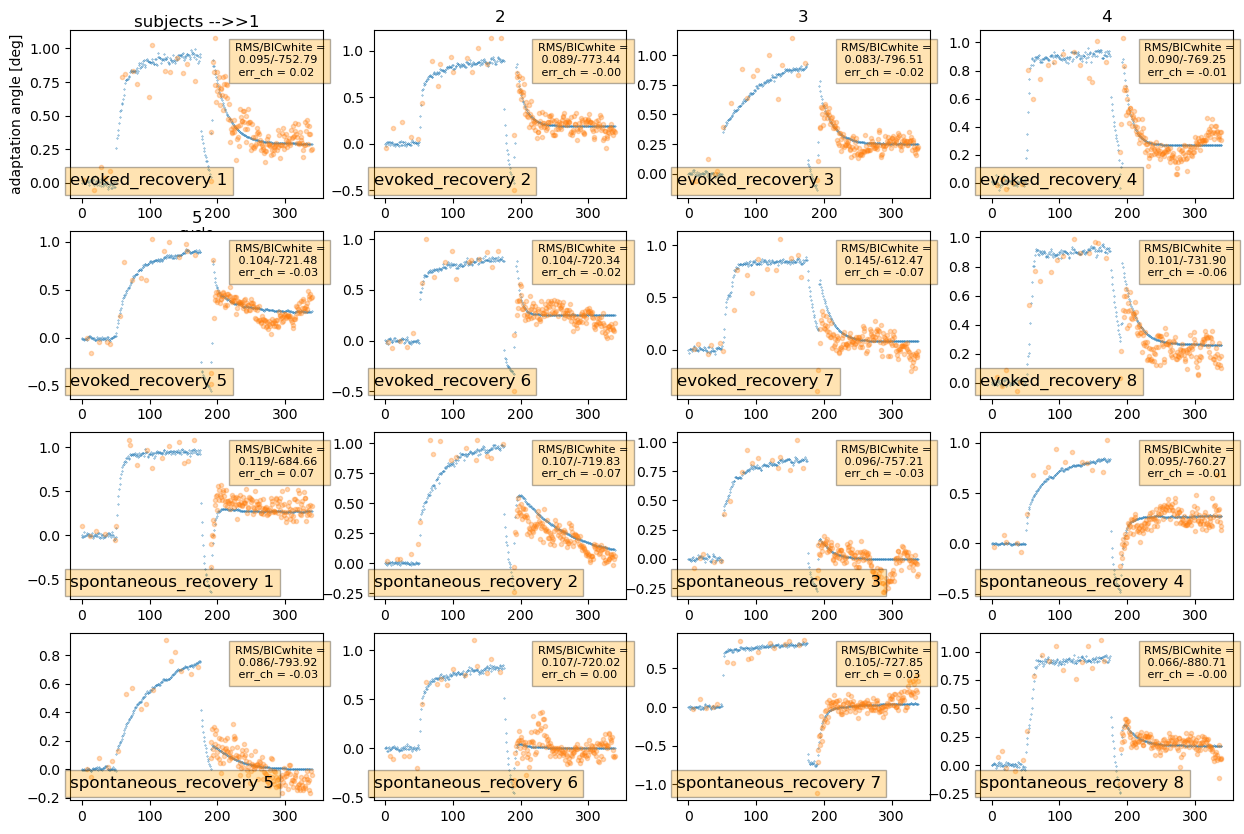

In [12]:
plt.figure(figsize=(15,10))
for k in opt_data:
    if k > 15:
        break
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    mse = np.nanmean((ydata_model-ydata_experiment)**2)
    rms = np.sqrt(mse)
    
    # computing BIC assuming white noise; 
    #TODO: integrate proper calculation based on actual likelihood
    bic_white = bic( ydata_experiment,ydata_model, 5) 

    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]


    plt.plot(outs[k],'.',linewidth=0.5, markersize=0.6)
    plt.plot(data[k],'.', alpha=0.3)

    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))

    plt.text(0.65, 0.82, f'RMS/BICwhite =\n {rms:.3f}/{bic_white:.2f}\n err_ch = {np.mean(ydata_experiment[-146:]-ydata_model[-146:]):.2f}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8,
                 bbox=dict(facecolor='orange', alpha=0.3))

plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)


